In [ ]:
%load_ext autoreload
%autoreload 2

# Text: Core

> The `text.core` module contains the core bits required to use fast.ai's low-level and/or mid-level APIs to build `DataLoaders` and train NLP/Text sequence classification models 

In [ ]:
# |default_exp text.core
# |default_cls_lvl 3

In [ ]:
# |export
from __future__ import annotations

import gc, importlib, sys, traceback

from accelerate.logging import get_logger
from dataclasses import dataclass
from datasets import concatenate_datasets, load_dataset
from dotenv import load_dotenv
from fastai.callback.all import *
from fastai.imports import *
from fastai.learner import *
from fastai.losses import BaseLoss, BCEWithLogitsLossFlat, CrossEntropyLossFlat
from fastai.data.transforms import DataLoaders, Datasets, ColSplitter, ItemTransform
from fastai.optimizer import Adam, OptimWrapper, params
from fastai.metrics import accuracy, F1Score, accuracy_multi, F1ScoreMulti
from fastai.test_utils import show_install
from fastai.torch_core import *
from fastai.torch_imports import *
from transformers import (
    AutoConfig,
    AutoTokenizer,
    PretrainedConfig,
    PreTrainedTokenizerBase,
    PreTrainedModel,
)
from transformers import AutoModelForSequenceClassification
from transformers import logging as hf_logging

from blurr.utils import clean_memory, get_hf_objects, set_seed, PreCalculatedLoss

In [ ]:
# |hide
import pdb

from fastai.data.block import (
    CategoryBlock,
    ColReader,
    ColSplitter,
    DataBlock,
    ItemGetter,
    RandomSplitter,
)
from fastai.text.data import SortedDL
from fastcore.test import *
import nbdev

from blurr.utils import (
    print_versions,
    PreCalculatedCrossEntropyLoss,
    PreCalculatedBCELoss,
    PreCalculatedMSELoss,
)

In [ ]:
# |export
# silence all the HF warnings and load environment variables
warnings.simplefilter("ignore")
hf_logging.set_verbosity_error()
logger = get_logger(__name__)

load_dotenv()

False

In [ ]:
# |hide
# |notest
torch.cuda.set_device(0)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")

Using GPU #0: NVIDIA GeForce RTX 3090


In [ ]:
# | echo: false
os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")

What we're running with at the time this documentation was generated:
torch: 1.13.1
fastai: 2.7.11
transformers: 4.26.1


## Setup

We'll use a subset of `imdb` to demonstrate how to configure your BLURR for sequence classification tasks. **BLURR** is designed to work with Hugging Face `Dataset` and/or pandas `DataFrame` objects

In [ ]:
imdb_dsd = load_dataset("imdb", split=["train", "test"])

# build HF `Dataset` objects
train_ds = (
    imdb_dsd[0]
    .add_column("is_valid", [False] * len(imdb_dsd[0]))
    .shuffle()
    .select(range(1000))
)
valid_ds = (
    imdb_dsd[1]
    .add_column("is_valid", [True] * len(imdb_dsd[1]))
    .shuffle()
    .select(range(200))
)

# build a `DataFrame` representation as well
imdb_ds = concatenate_datasets([train_ds, valid_ds])
imdb_df = pd.DataFrame(imdb_ds)

print(len(train_ds), len(valid_ds))
print(
    len(imdb_df[imdb_df["is_valid"] == False]),
    len(imdb_df[imdb_df["is_valid"] == True]),
)
imdb_df.head()

Found cached dataset imdb (/home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/2 [00:00<?, ?it/s]

1000 200
1000 200


,text,label,is_valid
0,"I enjoyed it. In general, I'm not a fan of comedies and comedians, but I do like Whoopi. I'm also partial to Sci/Fi Fantasy. And the dinosaur craze. I read for pleasure, but when I'm feeling over-stressed or really mind-dead, I watch TV & movies to escape. Theodore Rex enabled me to do so. That makes it a success in my eyes! I didn't even walk away to do something else while it was running. Whether or not it was rated as ""good"" or not doesn't really matter to me. And no, I'm not a juvenile. Nor am I a moron.",1,False
1,"Ok so I was bored and I watched it all the way through.<br /><br />This film is mild, inoffensive and lacklustre. The story is so sugary it rots your teeth on the opening titles. A tail of two 'traumatised' children learning about 'God' the fairy story way which frankly left me rather traumatised. It uses the Irish 'blarney' in such a stereotypical way one hopes no true Irish ever see it. Aimed at children who frankly would switch off after the first attempt at an 'OIRISH' accent. All in all why do they pump these out.",0,False
2,"This film is really bad. It maybe harsh, but it is. It really is. Poor script, every vampire cliché in the book is used, and no sympathy is given at all to the origins of the main character ... i.e. ole Dracula. There have been some truly brilliant Dracula/vampire movies in the past, but this doesn't even make it into the ""dire"" slot.<br /><br />Take a selection of people who seem to have dropped out of a teen-slasher move, add a dribble of Dracula Lore and mix in a heady tonic of religious/surreal day-dreaming ... and you get a confusing mess of a film - Dracula 2000.<br /><br />I really ...",0,False
3,"What is contained on this disk is a first rate show by a first rate band. This disc is NOT for the faint of heart...the music is incredibly intense, and VERY cool. What you will learn when you watch this movie is just why the Who was so huge for so long. It is true that their records were great, but their shows were the top of the heap. In 1969 when this concert was shot, the screaming teenie boppers that threw jelly beans at the Beatles were gone and bands (and audiences) had settled down to long and often amazing displays of musical virtuosity--something that few audiences have the intel...",1,False
4,"It isn't always easy to explain what a movie is like, but this time I think I've found it. It reminded me of two movies: Trainspotting (small time criminals scoring some drugs and doing some stupid things in Schotland) and The Blair Witch Project (because of the style of filming).<br /><br />It's about the loyalty between two friends, one of them is coming out of jail, the other one hasn't been caught yet. With a stolen vehicle they drive through the Scottish countryside but than run out of petrol. As they try to find some fuel, they find a farm in the middle of nowhere. The farmer thinks ...",1,False


In [ ]:
labels = imdb_dsd[0].features["label"].names
labels

['neg', 'pos']

## Core: Data

A base collation function

### `BlurrDataCollatorWithPadding` -

In [ ]:
# |export
@dataclass
class BlurrDataCollatorWithPadding:
    tokenizer: PreTrainedTokenizerBase
    padding: bool = True
    max_length: int = None
    pad_to_multiple_of: int = None
    return_tensors: str = "pt"
    n_inp: int = 1

    def __call__(self, features):
        features = L(features)

        batch = []
        inputs, labels, targs = [], [], []
        if isinstance(features[0], dict):
            feature_keys = list(features[0].keys())
            inputs = [
                {
                    fwd_arg_name: list(features.attrgot(fwd_arg_name))
                    for fwd_arg_name in self.tokenizer.model_input_names
                    if fwd_arg_name in feature_keys
                }
            ]
            labels = [
                torch.tensor(
                    list(features.attrgot("label")) if "label" in feature_keys else []
                )
            ]
            targs = labels
        elif isinstance(features[0], tuple):
            for f_idx in range(self.n_inp):
                feature_keys = list(features[0][f_idx].keys())
                inputs.append(
                    {
                        fwd_arg_name: list(
                            features.itemgot(f_idx).attrgot(fwd_arg_name)
                        )
                        for fwd_arg_name in self.tokenizer.model_input_names
                        if fwd_arg_name in feature_keys
                    }
                )
                labels.append(
                    torch.tensor(
                        list(features.itemgot(f_idx).attrgot("label"))
                        if "label" in feature_keys
                        else []
                    )
                )

            targs = [
                torch.tensor(list(features.itemgot(f_idx)))
                for f_idx in range(self.n_inp, len(features[0]))
            ]

        for input, input_labels in zip(inputs, labels):
            inp = dict(
                self.tokenizer.pad(
                    input,
                    padding=self.padding,
                    max_length=self.max_length,
                    pad_to_multiple_of=self.pad_to_multiple_of,
                    return_tensors=self.return_tensors,
                )
            )
            if len(input_labels) > 0:
                inp["labels"] = input_labels
            batch.append(dict(inp))

        for targ in targs:
            batch.append(targ)

        return batch

## Core: Training

Base splitter, model wrapper, and model callback

### `blurr_splitter`s -

In [ ]:
# |export
def blurr_splitter(m: Module):
    """Splits the Hugging Face model based on various model architecture conventions"""
    model = m.hf_model if (hasattr(m, "hf_model")) else m
    root_modules = list(model.named_children())
    top_module_name, top_module = root_modules[0]

    groups = L([m for m_name, m in list(top_module.named_children())])
    groups += L([m for m_name, m in root_modules[1:]])

    return groups.map(params).filter(lambda el: len(el) > 0)

In [ ]:
nbdev.show_doc(blurr_splitter, title_level=3)

---

### blurr_splitter

>      blurr_splitter (m:fastai.torch_core.Module)

Splits the Hugging Face model based on various model architecture conventions

In [ ]:
def blurr_splitter_on_head(m: Module):
    """Creates two layer groups: One for the backbone and one for the pooler/classification head"""
    model = m.hf_model if (hasattr(m, "hf_model")) else m
    root_modules = list(model.named_children())
    backbone_module_name, backbone_module = root_modules[0]

    groups = L(backbone_module)
    groups += L([m for m_name, m in root_modules[1:]]).concat()

    return groups.map(params).filter(lambda el: len(el) > 0)

In [ ]:
nbdev.show_doc(blurr_splitter_on_head, title_level=3)

---

### blurr_splitter_on_head

>      blurr_splitter_on_head (m:fastai.torch_core.Module)

Creates two layer groups: One for the backbone and one for the pooler/classification head

### `BaseModelWrapper` -

In [ ]:
# |export
class BaseModelWrapper(Module):
    def __init__(
        self,
        # Your Hugging Face model
        hf_model: PreTrainedModel,
        # If True, hidden_states will be returned and accessed from Learner
        output_hidden_states: bool = False,
        # If True, attentions will be returned and accessed from Learner
        output_attentions: bool = False,
        # Any additional keyword arguments you want passed into your models forward method
        hf_model_kwargs={},
    ):
        super().__init__()

        store_attr()
        self.hf_model = hf_model.cuda() if torch.cuda.is_available() else hf_model
        self.hf_model_fwd_args = list(
            inspect.signature(self.hf_model.forward).parameters.keys()
        )

    def forward(self, x):
        for k in list(x):
            if k not in self.hf_model_fwd_args:
                del x[k]

        return self.hf_model(
            **x,
            output_hidden_states=self.output_hidden_states,
            output_attentions=self.output_attentions,
            return_dict=True,
            **self.hf_model_kwargs
        )

Note that `BaseModelWrapper` includes some nifty code for just passing in the things your model needs, as not all transformer architectures require/use the same information.

### `BaseModelCallback` -

In [ ]:
# |export
class BaseModelCallback(Callback):
    def __init__(
        self,
        # Additional keyword arguments passed to `BaseModelWrapper`
        base_model_wrapper_kwargs: dict = {},
    ):
        self.base_model_wrapper_kwargs = base_model_wrapper_kwargs

    def after_create(self):
        if isinstance(self.learn.model, PreTrainedModel):
            self.learn.model = BaseModelWrapper(
                self.learn.model, **self.base_model_wrapper_kwargs
            )

    def before_batch(self):
        self.hf_loss = None

    def after_pred(self):
        model_outputs = self.pred
        self.learn.blurr_model_outputs = {}

        for k, v in model_outputs.items():
            # if the "labels" are included, we are training with target labels in which case the loss is returned
            if k == "loss" and isinstance(self.learn.loss_func, PreCalculatedLoss):
                self.hf_loss = to_float(v)
            # the logits represent the prediction
            elif k == "logits":
                self.learn.pred = v
            # add any other things included in model_outputs as blurr_{model_output_key}
            else:
                self.learn.blurr_model_outputs[k] = v

    def after_loss(self):
        # if we already have the loss from the model, update the Learner's loss to be it
        if self.hf_loss is not None:
            self.learn.loss_grad = self.hf_loss
            self.learn.loss = self.learn.loss_grad.clone()

We use a `Callback` for handling the [`ModelOutput`](https://huggingface.co/transformers/main_classes/output.html#transformers.file_utils.ModelOutput) returned by Hugging Face transformers. It allows us to associate anything we want from that object to our `Learner`.

**Note** that your `Learner`'s loss will be set for you only if the Hugging Face model returns one *and* you are using the `PreCalculatedLoss` loss function.  

Also note that anything else you asked the model to return (for example, last hidden state, etc..) will be available for you via the `blurr_model_outputs` property attached to your `Learner`. For example, assuming you are using BERT for a classification task ... if you have told your `BaseModelWrapper` instance to return attentions, you'd be able to access them via `learn.blurr_model_outputs['attentions']`.

## Core: Example (PyTorch)

This section demonstrates how you can use PyTorch to build your `DataLoader` iterators and train your model using the fast.ai `Learner`. Note that most fast.ai specific features such as `DataLoaders.one_batch`, `Learner.show_summary`, `DataLoader.show_batch`, `Learner.show_results` are not available when using PyTorch.

### Step 1: HF objects

In [ ]:
model_cls = AutoModelForSequenceClassification
hf_logging.set_verbosity_error()

pretrained_model_name = "microsoft/deberta-v3-small"
n_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
    pretrained_model_name, model_cls=model_cls, config_kwargs={"num_labels": n_labels}
)

test_eq(hf_arch, "deberta_v2")
hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

print("=== config ===")
print(f"# of labels:\t{hf_config.num_labels}")
print("")
print("=== tokenizer ===")
print(f"Vocab size:\t\t{hf_tokenizer.vocab_size}")
print(f"Max # of tokens:\t{hf_tokenizer.model_max_length}")
print(
    f"Attributes expected by model in forward pass:\t{hf_tokenizer.model_input_names}"
)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


### Step 2: `Dataset`s

We'll use the Hugging Face `Dataset` objects created in *Setup*, but these could just as well be instances of `torch.utils.data.Dataset`

In [ ]:
print("Train|Validation examples: ", len(train_ds), len(valid_ds))

print(train_ds[:2])
print("")
print(train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ['I enjoyed it. In general, I\'m not a fan of comedies and comedians, but I do like Whoopi. I\'m also partial to Sci/Fi Fantasy. And the dinosaur craze. I read for pleasure, but when I\'m feeling over-stressed or really mind-dead, I watch TV & movies to escape. Theodore Rex enabled me to do so. That makes it a success in my eyes! I didn\'t even walk away to do something else while it was running. Whether or not it was rated as "good" or not doesn\'t really matter to me. And no, I\'m not a juvenile. Nor am I a moron.', "Ok so I was bored and I watched it all the way through.<br /><br />This film is mild, inoffensive and lacklustre. The story is so sugary it rots your teeth on the opening titles. A tail of two 'traumatised' children learning about 'God' the fairy story way which frankly left me rather traumatised. It uses the Irish 'blarney' in such a stereotypical way one hopes no true Irish ever see it. Aimed at children who frankly would s

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_train_ds = train_ds.map(tokenize_func, batched=True)
proc_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

proc_valid_ds = valid_ds.map(tokenize_func, batched=True)
proc_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

print(proc_train_ds)
print(proc_valid_ds)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})
Dataset({
    features: ['text', 'label', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 200
})


### Step 3: `DataLoaders`

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = BlurrDataCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(
    proc_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator
)
valid_dl = torch.utils.data.DataLoader(
    proc_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator
)

dls = DataLoaders(train_dl, valid_dl)

In [ ]:
print(len(train_dl), len(valid_dl))

b = next(iter(train_dl))
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0]))
print("")
print(b[1])

# b

250 25
2

[CLS] This movie is not very good.In fact, it is the worst Elvis movie I have seen.It has very little plot,mostly partying,beer drinking and fighting. Burgess Meredith and Thomas Gomez are wasted. I don't know why they did this movie.You could say Elvis was wasted as well,he is much,much better in "Follow That Dream."[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][

### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

3


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

### Step 5: Train

SuggestedLRs(minimum=4.786300996784121e-05, steep=0.0003981071640737355, valley=0.00013182566908653826, slide=0.0010000000474974513)

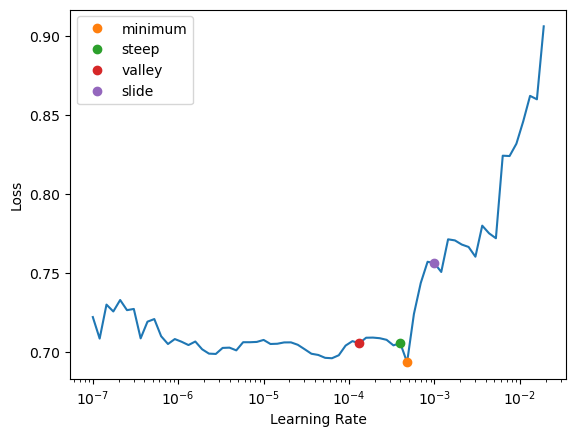

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.687901,0.671161,0.540000,00:22
1,0.269744,0.240634,0.890000,00:22
2,0.198055,0.222598,0.910000,00:22


In [ ]:
for m_name, m_val in zip(
    learn.recorder.metric_names[1:-1], learn.recorder.final_record
):
    print(m_name, m_val)

train_loss 0.1980551779270172
valid_loss 0.22259782254695892
accuracy 0.9100000262260437


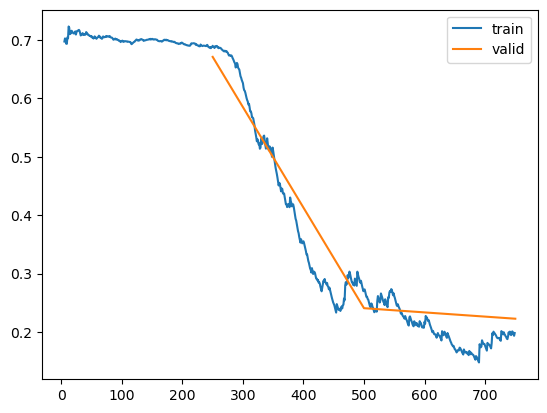

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test_topic_segmentation.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Low-Level API

This section demonstrates how you can migrate from using PyTorch to fast.ai `Datasets` and `DataLoaders` to recapture much of the fast.ai specific features unavailable when using basic PyTorch.

## Low-Level API: Example

### Step 1: HF objects

In [ ]:
model_cls = AutoModelForSequenceClassification
hf_logging.set_verbosity_error()

pretrained_model_name = "microsoft/deberta-v3-small"
n_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
    pretrained_model_name, model_cls=model_cls, config_kwargs={"num_labels": n_labels}
)

test_eq(hf_arch, "deberta_v2")
hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

print("=== config ===")
print(f"# of labels:\t{hf_config.num_labels}")
print("")
print("=== tokenizer ===")
print(f"Vocab size:\t\t{hf_tokenizer.vocab_size}")
print(f"Max # of tokens:\t{hf_tokenizer.model_max_length}")
print(
    f"Attributes expected by model in forward pass:\t{hf_tokenizer.model_input_names}"
)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


### Step 2: `Datasets`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_imdb_ds = imdb_ds.map(tokenize_func, batched=True)
proc_imdb_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

# turn Arrow into DataFrame (`ColSplitter` only works with `DataFrame`s)
train_df = pd.DataFrame(proc_imdb_ds)
train_df.head()

# define dataset splitter
splitter = ColSplitter("is_valid")
splits = splitter(imdb_df)

# define how we want to build our inputs and targets
def _build_inputs(example):
    return {
        fwd_arg_name: example[fwd_arg_name]
        for fwd_arg_name in hf_tokenizer.model_input_names
        if fwd_arg_name in list(example.keys())
    }


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(
    items=train_df, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1
)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [ ]:
print("Items in train|validation datasets: ", len(dsets.train), len(dsets.valid))

example = dsets.valid[0]
# example

print(f"Items in each example: {len(example)}")
print(f"Example inputs: {list(example[0].keys())}")
print(f"Example target(s): {example[1]}")

Items in train|validation datasets:  1000 200
Items in each example: 2
Example inputs: ['input_ids', 'token_type_ids', 'attention_mask']
Example target(s): 1


### Step 3: `DataLoaders`

In [ ]:
def sorted_dl_func(item):
    return len(item[0]["input_ids"])


data_collator = BlurrDataCollatorWithPadding(hf_tokenizer)
dls = dsets.dataloaders(
    batch_size=4,
    create_batch=data_collator,
    dl_type=partial(SortedDL, sort_func=sorted_dl_func),
)

In [ ]:
print(len(dls.train), len(dls.valid))

b = dls.valid.one_batch()
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0]))
print("")
print(b[1])

250 50
2

[CLS] This review is based on the Producer's Cut: <br /><br />'Halloween 5' was a major disappointment at the box office way back in '89. Personally, I've always loved it and am proud to have it in my collection. But because of it's failure and also because of rights issues, it would be 6 years before we would see another installment. The film had the makings of being one of the best, if not the best in the series. A hardcore fan writing the script, the return of not only Donald Pleasence as Dr. Loomis and George Wilbur as Michael Myers, but also the return of the character of Tommy Doyle from the first film, a major studio backing the project, and a Fall release all made the film sound like a hit in the making. So what went wrong? I'll give you two good reasons: Re-shoots and poor editing. Due to a bad test screening and also the unfortunate passing of Donald Pleasence, the film was changed, and not for the better. The film, like parts III and 5, tanked at the box office and

### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

3


In [ ]:
# NOPE: Will work assuming we define a suitable `show_batch()`` method for our examples
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# YES: Since we're using fastai `DataLoaders`, we get `one_batch()` back
learn.summary()

BaseModelWrapper (Input shape: 4 x 1454)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 1454 x 768      
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 1454 x 3072     
Linear                        

### Step 5: Train

SuggestedLRs(minimum=5.248074739938602e-06, steep=0.0063095735386013985, valley=1.737800812406931e-05, slide=0.0008317637839354575)

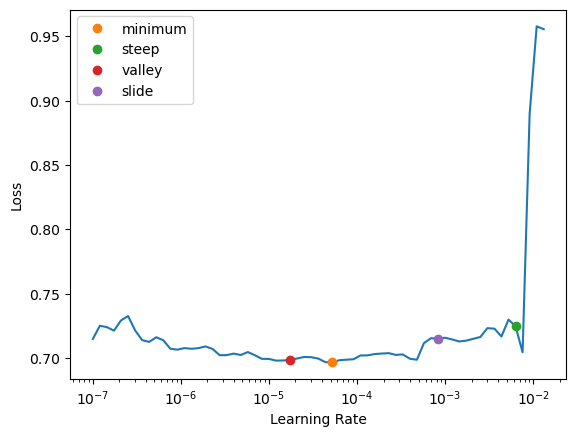

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.696451,0.665011,0.540000,00:19
1,0.275876,0.231709,0.915000,00:19
2,0.202718,0.228153,0.915000,00:20


In [ ]:
for m_name, m_val in zip(
    learn.recorder.metric_names[1:-1], learn.recorder.final_record
):
    print(m_name, m_val)

train_loss 0.20271793007850647
valid_loss 0.22815324366092682
accuracy 0.9150000214576721


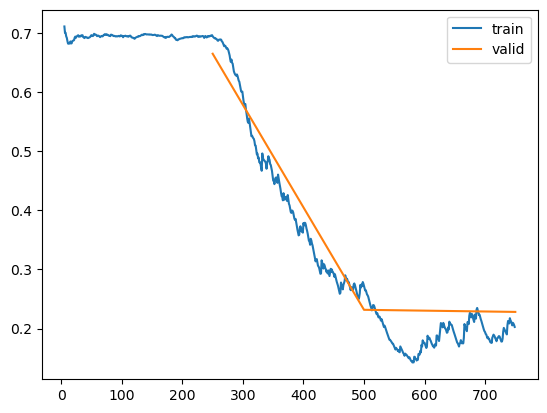

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results()

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
# AttributeError: 'DataLoader' object has no attribute 'new'
learn.export("../models/test_text_core_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Tests

The tests below to ensure the core DataBlock code above works for **all** pretrained sequence classification models available in Hugging Face.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained classification models you are working with ... and if any of your pretrained sequence classification models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

## Mid-level API

### Tests

The tests below to ensure the core DataBlock code above works for **all** pretrained sequence classification models available in Hugging Face.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained classification models you are working with ... and if any of your pretrained sequence classification models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

## Export -

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()